In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers
from glob import glob
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications import InceptionV3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install split_folders

In [4]:
#splitting the data
import splitfolders
 
input = "/content/drive/MyDrive/Category"
Output = "/content/drive/MyDrive" #where you want the split datasets saved. one will be created if none is set
 
splitfolders.ratio(input, output="Output", seed=42, ratio=(0.8,0.2))

Copying files: 718 files [02:26,  4.92 files/s]


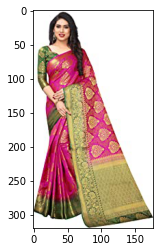

In [5]:
from keras.preprocessing.image import load_img
img = load_img("/content/drive/MyDrive/Images/img3 (3).jpg")
plt.imshow(img)

In [6]:
# RE-SIZE
IMAGE_SIZE = [80,80]
 
train_path = '/content/Output/train'
valid_path = '/content/Output/val'

In [7]:
# import inception v3 library and using imagenet as weights 
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet',include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [8]:
# dont train exist weights
for layer in inception.layers:
  layer.trainable=False

In [9]:
from tensorflow.keras import layers
x = layers.Flatten()(inception.output)

In [10]:
x = Flatten()(inception.output)

In [11]:
# useful for number of outclass
folders = glob('/content/Output/train')

In [12]:
prediction = Dense(len(folders), activation='softmax')(x)

In [13]:
# creating model object
model = Model(inputs=inception.input, outputs=prediction)

In [14]:
#model structure
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 39, 39, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 39, 39, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 39, 39, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

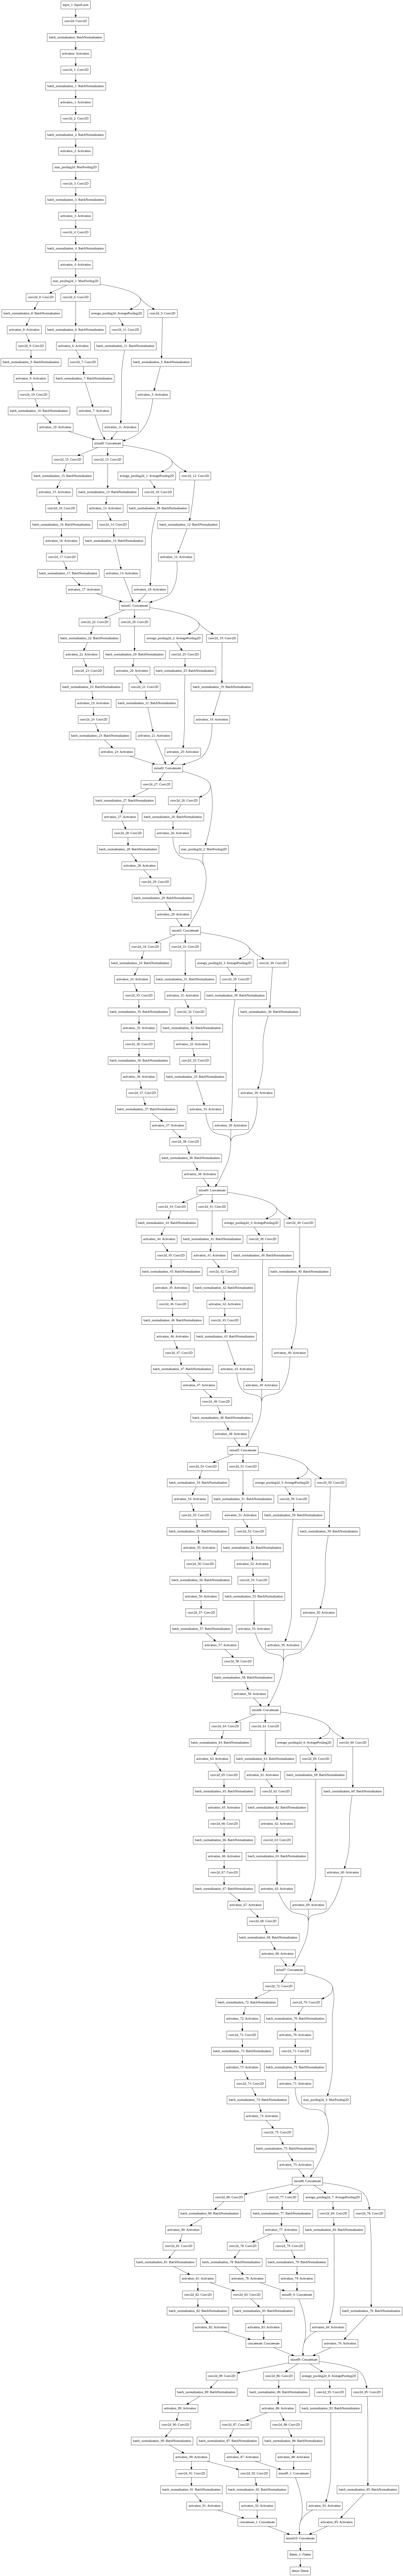

In [15]:
import pydot
keras.utils.plot_model(model)

In [16]:
#model cost and optimization
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
 
test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/Output/train',
                                                 target_size = (80,80),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 574 images belonging to 3 classes.


In [19]:
test_set = test_datagen.flow_from_directory('/content/Output/val',
                                            target_size = (80,80),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 144 images belonging to 3 classes.


In [20]:
training_set.class_indices

{'Jeans': 0, 'Saree': 1, 'Trouser': 2}

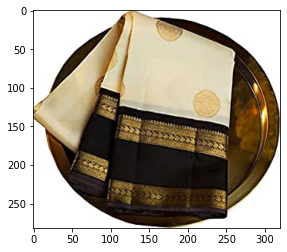

In [21]:
img = load_img('/content/drive/MyDrive/Images/img32 (3).jpg')
plt.imshow(img)

In [22]:
# fit the model
fitting = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
36/36 [==============================] - 13s 254ms/step - loss: 0.5773 - accuracy: 0.8235 - val_loss: 0.4030 - val_accuracy: 0.8889
Epoch 2/20
36/36 [==============================] - 7s 206ms/step - loss: 0.3481 - accuracy: 0.9152 - val_loss: 0.3219 - val_accuracy: 0.9144
Epoch 3/20
36/36 [==============================] - 7s 208ms/step - loss: 0.2888 - accuracy: 0.9338 - val_loss: 0.2817 - val_accuracy: 0.9213
Epoch 4/20
36/36 [==============================] - 7s 207ms/step - loss: 0.2331 - accuracy: 0.9495 - val_loss: 0.2452 - val_accuracy: 0.9259
Epoch 5/20
36/36 [==============================] - 7s 206ms/step - loss: 0.2391 - accuracy: 0.9373 - val_loss: 0.2304 - val_accuracy: 0.9306
Epoch 6/20
36/36 [==============================] - 7s 206ms/step - loss: 0.2022 - accuracy: 0.9547 - val_loss: 0.2367 - val_accuracy: 0.9213
Epoch 7/20
36/36 [==============================] - 7s 206ms/step - loss: 0.1854 - accuracy: 0.9535 - val_loss: 0.2124 - val_accuracy: 0.9213
Epoch

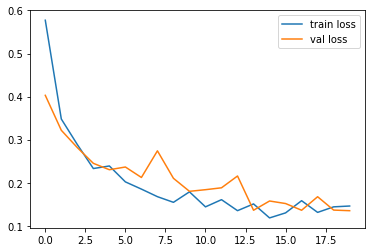

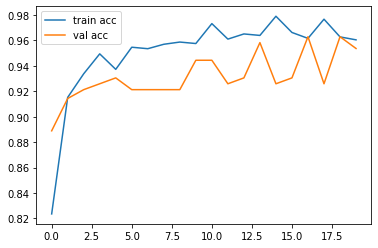

<Figure size 432x288 with 0 Axes>

In [23]:
#plot the loss
plt.plot(fitting.history['loss'],label='train loss')
plt.plot(fitting.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('loss_val')

#plot the accuracy
plt.plot(fitting.history['accuracy'],label='train acc')
plt.plot(fitting.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()
plt.savefig('accuracyval')

In [24]:
# We got good accuracy but let's do hyper parameter tuning 
def build_model(hyperparameter):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hyperparameter.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hyperparameter.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(80,80,3)
    ),
    keras.layers.Conv2D(
        filters=hyperparameter.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hyperparameter.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hyperparameter.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(3, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.RMSprop(hyperparameter.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy']
  )
  
  return model

In [25]:
pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 5.3 MB/s 


In [26]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [27]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=3,directory='Result',project_name="Image Classification")

In [28]:
tuner_search.search(training_set,epochs=10,validation_data=test_set)

Trial 3 Complete [00h 22m 20s]
val_accuracy: 0.8472222089767456

Best val_accuracy So Far: 0.9305555820465088
Total elapsed time: 00h 33m 49s
INFO:tensorflow:Oracle triggered exit


In [29]:
model=tuner_search.get_best_models(num_models=1)[0]

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 48)        1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 76, 80)        34640     
_________________________________________________________________
flatten (Flatten)            (None, 462080)            0         
_________________________________________________________________
dense (Dense)                (None, 48)                22179888  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 147       
Total params: 22,216,019
Trainable params: 22,216,019
Non-trainable params: 0
_________________________________________________________________


In [31]:
bg=model.fit(training_set,validation_data=test_set,epochs=10)

Epoch 1/10
36/36 [==============================] - 26s 714ms/step - loss: 0.2833 - accuracy: 0.9024 - val_loss: 0.1060 - val_accuracy: 0.9653
Epoch 2/10
36/36 [==============================] - 25s 702ms/step - loss: 0.2313 - accuracy: 0.9007 - val_loss: 0.1373 - val_accuracy: 0.9167
Epoch 3/10
36/36 [==============================] - 25s 705ms/step - loss: 0.2383 - accuracy: 0.9286 - val_loss: 0.1532 - val_accuracy: 0.9444
Epoch 4/10
36/36 [==============================] - 26s 720ms/step - loss: 0.2254 - accuracy: 0.9129 - val_loss: 0.3503 - val_accuracy: 0.9375
Epoch 5/10
36/36 [==============================] - 26s 715ms/step - loss: 0.1242 - accuracy: 0.9477 - val_loss: 0.4251 - val_accuracy: 0.8542
Epoch 6/10
36/36 [==============================] - 26s 712ms/step - loss: 0.1718 - accuracy: 0.9408 - val_loss: 0.3333 - val_accuracy: 0.9028
Epoch 7/10
36/36 [==============================] - 27s 745ms/step - loss: 0.1942 - accuracy: 0.9443 - val_loss: 0.0999 - val_accuracy: 0.9444

In [100]:
# test the model
from google.colab import files
uploaded = files.upload()

Saving img167.jpg to img167.jpg


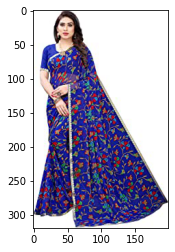

In [101]:
# image file
new_image = plt.imread('img167.jpg')
img = plt.imshow(new_image)

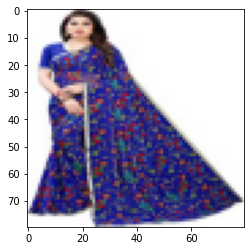

In [102]:
#resize image
from skimage.transform import resize
resized_image = resize(new_image,(80,80,3))
img = plt.imshow(resized_image)

In [103]:
#model predictions
predictions = model.predict(np.array([resized_image]))
 
predictions

array([[3.6682714e-23, 1.0000000e+00, 8.2262754e-24]], dtype=float32)

In [104]:
# sort predictions
list_index = [0,1,2]
x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] < x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

print(list_index)

[2, 0, 1]


In [105]:
training_set.class_indices

{'Jeans': 0, 'Saree': 1, 'Trouser': 2}

In [106]:
classification = ['Jeans','Saree','Trouser']

In [107]:
#predicted image name is
classification[list_index[i]]

'Saree'